In [10]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense,Dropout
from tensorflow.keras.models import Model

# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 10
NUM_CLASSES = 3  # Change based on the number of diseases
EPOCHS = 1
CARDINALITY = 8  # ResNeXt-specific parameter

# Paths to datasets
train_dir = "C:/Users/surya/Downloads/dogSkinDisease/train"
val_dir = "C:/Users/surya/Downloads/dogSkinDisease/validation"
test_dir = "C:/Users/surya/Downloads/dogSkinDisease/test"

# Data Augmentation


In [11]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)



Found 826 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [12]:
# Define ResNeXt block
def resnext_block(input_tensor, filters, cardinality, strides=1):
    group_width = filters // cardinality

    # 1x1 Convolution
    x = Conv2D(filters, (1, 1), strides=strides, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Grouped 3x3 Convolution
    grouped_channels = []
    for i in range(cardinality):
        slice_start = i * group_width
        slice_end = slice_start + group_width
        group = x[..., slice_start:slice_end]
        group = Conv2D(group_width, (3, 3), padding='same')(group)
        grouped_channels.append(group)

    x = tf.concat(grouped_channels, axis=-1)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # 1x1 Convolution
    x = Conv2D(filters * 2, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)

    # Add shortcut
    if strides != 1 or input_tensor.shape[-1] != filters * 2:
        shortcut = Conv2D(filters * 2, (1, 1), strides=strides, padding='same')(input_tensor)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = input_tensor

    x = Add()([x, shortcut])
    x = ReLU()(x)

    return x


# Build ResNeXt-50 model
def build_resnext50(input_shape=(224, 224, 3), num_classes=3, cardinality=32):
    input_tensor = Input(shape=input_shape)

    # Initial Convolution and MaxPooling
    x = Conv2D(64, (7, 7), strides=2, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=2, padding='same')(x)

    # ResNeXt Blocks
    x = resnext_block(x, filters=128, cardinality=cardinality, strides=1)  # Stage 1
    x=Dropout(0.3)(x)
    x = resnext_block(x, filters=128, cardinality=cardinality, strides=1)  # Stage 1
    x=Dropout(0.3)(x)
    x = resnext_block(x, filters=256, cardinality=cardinality, strides=2)  # Stage 2
    x=Dropout(0.3)(x)
    x = resnext_block(x, filters=256, cardinality=cardinality, strides=1)  # Stage 2
    x=Dropout(0.3)(x)
    x = resnext_block(x, filters=512, cardinality=cardinality, strides=2)  # Stage 3
    x=Dropout(0.3)(x)
    x = resnext_block(x, filters=512, cardinality=cardinality, strides=1)  # Stage 3
    x=Dropout(0.3)(x)

    # Global Average Pooling and Dense Layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x=Dropout(0.5)(x)
    output_tensor = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)
    return model


In [13]:
# Instantiate and compile the model
model = build_resnext50(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=NUM_CLASSES, cardinality=CARDINALITY)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
history = model.fit(train_generator,epochs=EPOCHS, validation_data=val_generator, callbacks=[lr_scheduler])

83/83 [==============================] - 170s 2s/step - loss: 1.8041 - accuracy: 0.3668 - val_loss: 1.1563 - val_accuracy: 0.3167 - lr: 0.0010


In [14]:
# Save the trained model
# model.save("dog_skinggg.h5")



In [15]:
# Evaluate the model on the test set
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='categorical'
)

test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.2f}")

Found 60 images belonging to 3 classes.


60/60 [==============================] - 4s 69ms/step - loss: 1.1345 - accuracy: 0.3167
Test Accuracy: 0.32


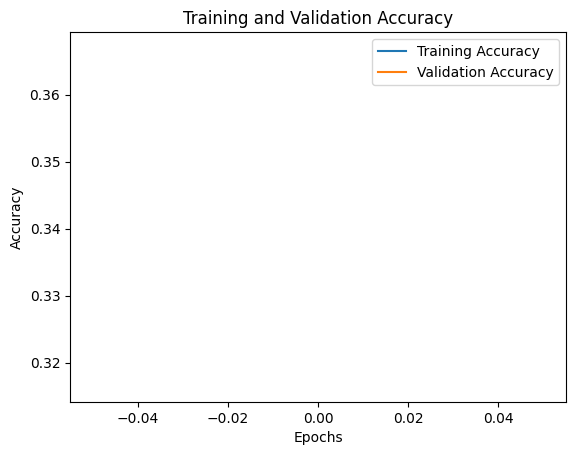

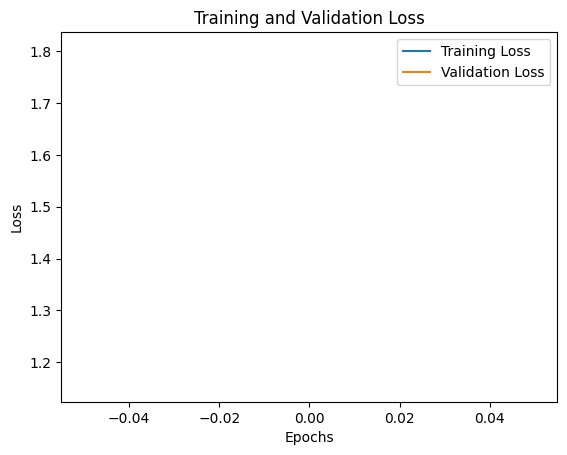

In [16]:
import matplotlib.pyplot as plt

# Plotting accuracy
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plotting loss
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the functions
plot_accuracy(history)
plot_loss(history)


60/60 [==============================] - 5s 65ms/step


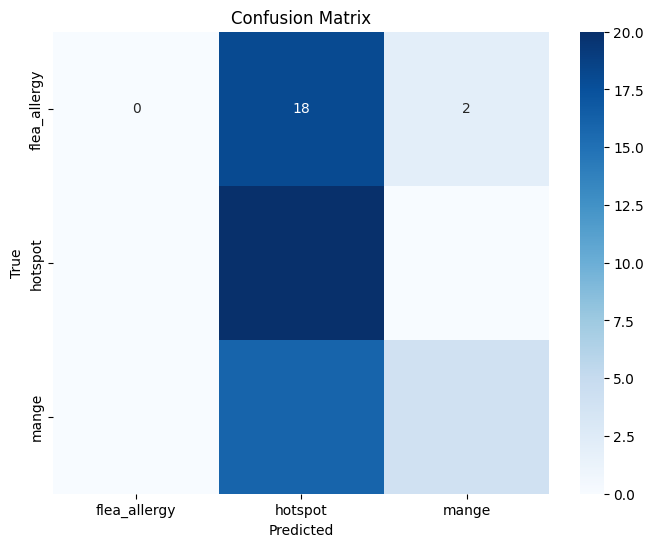

              precision    recall  f1-score   support

flea_allergy       0.00      0.00      0.00        20
     hotspot       0.37      1.00      0.54        20
       mange       0.67      0.20      0.31        20

    accuracy                           0.40        60
   macro avg       0.35      0.40      0.28        60
weighted avg       0.35      0.40      0.28        60



d:\python files\Dog_skin_disease\.venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python files\Dog_skin_disease\.venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\python files\Dog_skin_disease\.venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get the true labels and predictions
y_true = test_generator.classes
y_pred = np.argmax(model.predict(test_generator), axis=-1)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Call the function with class labels
labels = list(train_generator.class_indices.keys())  # Extract class labels
plot_confusion_matrix(cm, labels)

# Print classification report (precision, recall, f1-score)
print(classification_report(y_true, y_pred, target_names=labels))


In [18]:
from sklearn.metrics import precision_recall_fscore_support

# Get precision, recall, and f1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

# Print the metrics for each class
for i, label in enumerate(labels):
    print(f"Class: {label}")
    print(f"Precision: {precision[i]:.4f}")
    print(f"Recall: {recall[i]:.4f}")
    print(f"F1-score: {f1[i]:.4f}")
    print("-----")


Class: flea_allergy
Precision: 0.0000
Recall: 0.0000
F1-score: 0.0000
-----
Class: hotspot
Precision: 0.3704
Recall: 1.0000
F1-score: 0.5405
-----
Class: mange
Precision: 0.6667
Recall: 0.2000
F1-score: 0.3077
-----


d:\python files\Dog_skin_disease\.venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
